In [1]:
1import platform

global systemDivide
global RecursionBorder
RecursionBorder = 1_000_000

if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

import sys
import threading

threading.stack_size(2**27)
sys.setrecursionlimit(10 ** 5)

In [2]:
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.model_selection import ParameterGrid
from sklearn import linear_model

pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)

In [10]:
def create_strategy_config(params):
    """
    Создает удобную сетку для дальнейших расчетов
    :param params: начальные init параметры
    :return: словарь из параметров использующийся везде
    """
    capital = 20_000
    slippage = 2
    retParams = {
        # Капитал
        'capital': capital,
        'slippage': slippage,
        # Можно использовать для стоп лоссов и тейков с учетом слипэджа
        'slippagePerCapital': slippage / capital,
        # То какой размах мы будем брать для построения полос Боллинджера. Это и есть X Threshold из файла Евгения
        'yThreshold': round(params['yThreshold'] / 100, 2),
        # Период за который мы строим малую скользяшку
        'rollingMean': None,
        # Период за который мы строим большую скользяшку
        'fatRollingMean': None,
        # Временной барьер, Максимальное время сколько мы можем держать позицию
        'timeBarrier': None,
        # Параметр для определения того что данные MeanReversion/TrendFollowing
        # Используется в VRratio тестах для открытия/удержания позиции
        'varianceRatioFilter': params['varianceRatioFilter'],
        'reverseVarianceRatioFilter': params['reverseVarianceRatioFilter'],
        # Сколько времени мы не торгуем после срабатывания стоп лосса
        'restAfterLoss': params['restAfterLoss'],
        # Сколько времени мы не торгуем после закрытия позиции о большую скользяшку
        'restAfterFatProfit' : params['restAfterFatProfit'],
        # Процент стоп лосса
        'stopLossStdMultiplier': round(params['stopLossStdMultiplier'] / 100, 3),
        # Процент тэйк профита
        'takeProfitStdMultiplier': round(params['takeProfitStdMultiplier'] / 100, 3),
        # Нужно чтобы пересчитывать VR границы в автоматическом режиме
        'varianceRatioCarreteParameter': params['varianceRatioCarreteParameter'],
        # Тот период за который мы будем считать Variance Ratio. Те ставя тут к примеру 1500, мы должны будем передавать в функцию
        # VR Ratio 1500 точек данных. Сейчас этот гипермараметр связан с гиперпараметров периода малой скользяшки
        'varianceLookBack': None,
        # Чему будет равен временной лаг Q; Q = varianceLookBack // PARAM + 1
        'varianceRatioCarrete': None,
        # Параметр по которому мы будем искать период полураспада
        'scanHalfTime': int(params['scanHalfTime']),
        #
        'halfToFat': params['halfToFat'],
        #
        'halfToLight': params['halfToLight'],
        #
        'halfToTime': params['halfToTime'],

    }
    return retParams

grid_params = {
    # Оптимизировать !!!
    'yThreshold': [300, 200],
    # Оптимизировать !
    'varianceRatioFilter': [0.9],
    # Оптимизировать !
    'reverseVarianceRatioFilter': [0.95],
    # Оптимизировать !!
    'restAfterLoss': [90],
    # Оптимизировать !
    'restAfterFatProfit' : [250],
    # Оптимизировать !!
    'stopLossStdMultiplier': [1620],
    # Оптимизировать !
    'takeProfitStdMultiplier': [920],
    # Оптимизировать !!
    'varianceRatioCarreteParameter': [10],
    # Оптимизировать !!!
    'scanHalfTime': [1500],
    # Оптимизировать 0!
    'halfToFat': [3.0],
    # Оптимизировать 0!
    'halfToLight': [1.0],
    # Оптимизировать 0!
    'halfToTime': [1.0],
    }

grid_params = ParameterGrid(grid_params)
grid_params = pd.DataFrame(grid_params).sample(frac=1, random_state=9).reset_index(drop=True)
create_strategy_config(grid_params.iloc[0])

{'capital': 20000,
 'slippage': 2,
 'slippagePerCapital': 0.0001,
 'yThreshold': 2.0,
 'rollingMean': None,
 'fatRollingMean': None,
 'timeBarrier': None,
 'varianceRatioFilter': 0.9,
 'reverseVarianceRatioFilter': 0.95,
 'restAfterLoss': 90.0,
 'restAfterFatProfit': 250.0,
 'stopLossStdMultiplier': 16.2,
 'takeProfitStdMultiplier': 9.2,
 'varianceRatioCarreteParameter': 10.0,
 'varianceLookBack': None,
 'varianceRatioCarrete': None,
 'scanHalfTime': 1500,
 'halfToFat': 3.0,
 'halfToLight': 1.0,
 'halfToTime': 1.0}

In [4]:
def cook_data(df: pd.DataFrame, params) -> pd.DataFrame:
    """
    Подготавливает данные для дальнейшего рассчета стратегии.
    :param df: должен быть open, close, low, high
    :param params: список параметров из create_grid
    :return: данные с полосами Болинджера + логарифмы + возвраты
    """
    df['rollMean'] = df['open'].rolling(window=params['rollingMean']).mean()
    df['rollingStd'] = df['open'].rolling(window=params['rollingMean']).std()
    df['fatMean'] = df['open'].rolling(window=params['fatRollingMean']).mean()
    df['logOpenPrice'] = np.log(df['open'])
    df['retOpenPrice'] = df['logOpenPrice'].diff()
    return df.iloc[1:]

def get_half_time(openTuple: pd.Series) -> float:
    df_open = openTuple.to_frame()
    df_lag = df_open.shift(1)
    df_delta = df_open - df_lag
    linear_regression_model = linear_model.LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta), 1)
    df_lag = df_lag.values.reshape(len(df_lag), 1)
    linear_regression_model.fit(df_lag[1:], df_delta[1:])
    half_life = -np.log(2) / linear_regression_model.coef_.item()
    return half_life

def variance_ratio(logTuple: tuple, retTuple: tuple, params: dict) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    buffer_size = len(retTuple)
    means = (1 / buffer_size) * np.sum(retTuple)
    # сдвиг во времени q
    m = params['varianceRatioCarrete'] * (buffer_size - params['varianceRatioCarrete'] + 1 ) * (1 - (params['varianceRatioCarrete'] / buffer_size))
    sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
    subtract_returns = np.subtract(logTuple, np.roll(logTuple, params['varianceRatioCarrete']))[params['varianceRatioCarrete']:]
    _buff_ = np.sum(np.square(subtract_returns - params['varianceRatioCarrete'] * means))
    try:
        sigma_b = (1 / m) * _buff_
    except ZeroDivisionError:
        return False

    result = (sigma_b / sigma_a)
    if result < params['varianceRatioFilter']:
        return True
    else:
        return False

def reverse_variance_ratio(preComputed,params: dict, timeBorderCounter: int, VRstatement=False) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    retTuple = preComputed["retOpenPrice"]
    logTuple = preComputed["logOpenPrice"]
    if timeBorderCounter < params["varianceLookBack"]:
        buffer_size = len(retTuple)
        means = (1 / buffer_size) * np.sum(retTuple)
        # сдвиг во времени q
        m = timeBorderCounter * (buffer_size - timeBorderCounter + 1 ) * (1 - (timeBorderCounter / buffer_size))
        sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
        subtract_returns = np.subtract(logTuple, np.roll(logTuple, timeBorderCounter))[timeBorderCounter:]
        _buff_ = np.sum(np.square(subtract_returns - timeBorderCounter * means))
        sigma_b = (1 / m) * _buff_
        result = (sigma_b / sigma_a)
        if not VRstatement:
            if result > params['reverseVarianceRatioFilter']:
                return True
            else:
                return False
        if VRstatement:
            if result < params['varianceRatioFilter']:
                return True
            else:
                return False
    else:
        return False

def calculate_max_drawdown(PNL_SERIES, dollars=True):
    """
    solution by Marco de Prado
    :param PNL_SERIES:
    :param dollars:
    :return:
    """
    dropout_df = PNL_SERIES.to_frame('pnl')
    dropout_df['hwm'] = dropout_df.expanding().max()
    df0 = dropout_df.groupby('hwm').min().reset_index()
    df0.columns = ['hwm', 'min']
    df0 = df0[df0['hwm'] > df0['min']]
    if dollars:
        dd = df0['hwm'] - df0['min']
    else:
        dd = df0['min'] / df0['hwm']

    return max(dd)

def open_position(position, dataFrame, params, reqCounter, preComputed):
    TRIGGER = False
    localParams = params.copy()
    openDict = {
        'typeOperation': None,
        'position': None,
        'openPrice': None,
        'openIndex': None,
        'stopLossBorder': None,
        'takeProfitBorder': None
    }
    if reqCounter > RecursionBorder:
        return position

    # Получить время полураспада для генерации параметров сделки
    half_time = int(get_half_time(dataFrame.close[position-params['scanHalfTime']:position]))
    if (half_time > params['scanHalfTime']) or (half_time < 0):
        return open_position(position=position+1, dataFrame=dataFrame, params=params, reqCounter=reqCounter+1, preComputed=preComputed)

    localParams["rollingMean"] = int(half_time * params['halfToLight'])
    localParams["fatRollingMean"] = int(params['halfToFat'] * half_time)
    localParams["timeBarrier"] = int(half_time * params['halfToTime'])
    if localParams["timeBarrier"] <= 0:
        localParams["timeBarrier"] = 1

    localParams["varianceLookBack"] = int(half_time * params['halfToFat'])
    localParams["varianceRatioCarrete"] = int((half_time * params['halfToFat']) // params['varianceRatioCarreteParameter']) + 1
    # Считаем локальные барьеры открытия сделки
    bands_roll = dataFrame.open.iloc[position-half_time:position].rolling(localParams["rollingMean"])
    bands_mean = bands_roll.mean().iloc[-1]
    bands_std = bands_roll.std().iloc[-1]
    low_band = round(bands_mean - bands_std * params['yThreshold'],3)
    high_band = round(bands_mean + bands_std * params['yThreshold'],3)

    if (dataFrame.open[position] > low_band) and (dataFrame.low[position] < low_band):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=preComputed["logTuple"][position - localParams['varianceLookBack']:position],
                      retTuple=preComputed["retTuple"][position - localParams['varianceLookBack']:position],params=localParams):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'BUY'
            openDict['position'] = round(params['capital'] / low_band, 3)
            openDict['openPrice'] = low_band
            openDict['openIndex'] = position
            openDict['stopLossBorder'] = round(low_band - params['stopLossStdMultiplier'] * bands_std,3)
            openDict['takeProfitBorder'] = round(low_band + params['takeProfitStdMultiplier'] * bands_std,3)
            TRIGGER = True
            return {'openDict': openDict, 'params': localParams}

    elif (dataFrame.open[position] < high_band) and (dataFrame.high[position] > high_band):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=preComputed["logTuple"][position - localParams['varianceLookBack']:position],
                      retTuple=preComputed["retTuple"][position - localParams['varianceLookBack']:position],params=localParams):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'SELL'
            openDict['position'] = round(-1 * (params['capital'] / high_band), 3)
            openDict['openPrice'] = high_band
            openDict['openIndex'] = position
            openDict['stopLossBorder'] = round(high_band + params['stopLossStdMultiplier'] * bands_std,3)
            openDict['takeProfitBorder'] = round(high_band - params['takeProfitStdMultiplier'] * bands_std,3)
            TRIGGER = True
            return {'openDict': openDict, 'params': localParams}

    # В случае, если сделку открыть не получилось, переходим к следующей точке. Вывод - пока что сделку не получилось
    # В real-time это является аналогом ожидания до появления следующих данных и повторения проверки на открытие уже на них
    if not TRIGGER:
        return open_position(position=position+1, dataFrame=dataFrame, params=params, reqCounter=reqCounter+1, preComputed=preComputed)

def close_position(position, openDict, dataFrame, localParams, reqCounter, preComputed, borderCounter, indicatorVR):
    TRIGGER = False
    if reqCounter > RecursionBorder:
        return [position, localParams, borderCounter, indicatorVR]

    if borderCounter == localParams['timeBarrier']:
        return {'typeHolding': 'endPeriod', 'closePrice': dataFrame.open[position+1],
                        'closeIndex': position+1}

    elif openDict['typeOperation'] == 'BUY':
        # Стоп лосс условие
        if (dataFrame.open[position] > openDict['stopLossBorder']) and (dataFrame.low[position] < openDict['stopLossBorder']):
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': position}
        if dataFrame.open[position] < openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': dataFrame.open[position],
                        'closeIndex': position}
        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой. Причина этого такая же как для open_position
        # Читай в чем суть - выше!
        elif (dataFrame.open[position] < preComputed["rollMean"][position]) and (not indicatorVR):
            # Проверяем что можно закрыть лонг о пересечение с малой скользящей
            if dataFrame.high[position] > preComputed["rollMean"][position]:
                # Проверяем можно ли продолжить удержание позиции. Делаем это через VariacneRatio за какой-то период
                # arrowIndex - params['varianceLookBack'], где varianceLookBack - гиперпараметр стратегии.
                # Временной лаг Q для VARIANCE_RATIO определяется как время что мы находимся в позиции
                # Если VarianceRatio показывает что данные стали TrendFollowing - мы меняем режим стратегии на попытку закерыться
                # О скользящее среднее за больший период. Так мы получим большую прибыль
                if preComputed["rollMean"][position] < preComputed["fatMean"][position]:
                    if reverse_variance_ratio(preComputed=preComputed,
                                      params=localParams, timeBorderCounter=borderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                              openDict=openDict, localParams=localParams, preComputed=preComputed,
                                              borderCounter=borderCounter+1, indicatorVR=True)

                    else:
                        # Если VR RATIO не показал возможность попытаться закрыться о большую скользяшку, то закрываемся
                        # о малую
                        return {'typeHolding': 'lightCross', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position }
                        pass

                else:
                    # Может быть так, что скольщяшее среднее за больший период находится выше чем скользящее за малый период
                    # Если учесть что мы торгуем на тех инструментах что показывают большую склонность к meanReversion
                    # такая ситуцация говорит нам что нужно как можно скорей сбрасывать позицию.
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position + localParams['restAfterFatProfit']}

        # Определяет режим работы в случае альтернативной стратегии на которую мы переключаеся в случае выполнения каких-то условий
        if indicatorVR:
            # Аналогично тому что было раньше
            if dataFrame.open[position] < preComputed["fatMean"][position]:
                # Аналогично тому что было раньше
                if dataFrame.high[position] > preComputed["fatMean"][position]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': preComputed["fatMean"][position],
                            'closeIndex': position}
                # Даем возможность переключить режим стратегии снова на нулевой. Делаем это если данные снова начали показывать
                # склонность к meanReversion
                # if variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                #       retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                #     indicatorVR = False
                # ANOTHER LOGIC
            if not reverse_variance_ratio(preComputed=preComputed,
                                  params=localParams, timeBorderCounter=borderCounter+1, VRstatement=True):
                    #   Local Trend Following recursion
                return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                          openDict=openDict, localParams=localParams, preComputed=preComputed,
                                          borderCounter=borderCounter+1, indicatorVR=False)


    elif openDict['typeOperation'] == 'SELL':
        # Стоп лосс условие
        if (dataFrame.open[position] < openDict['stopLossBorder']) and (dataFrame.high[position] > openDict['stopLossBorder']):
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': position}
        if dataFrame.open[position] > openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': dataFrame.open[position],
                        'closeIndex': position}
        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой. Причина этого такая же как для open_position
        # Читай в чем суть - выше!

        elif (dataFrame.open[position] > preComputed["rollMean"][position]) and (not indicatorVR):
            # Проверяем что можно закрыть лонг о пересечение с малой скользящей
            if dataFrame.low[position] < preComputed["rollMean"][position]:
                # Проверяем можно ли продолжить удержание позиции. Делаем это через VariacneRatio за какой-то период
                # arrowIndex - params['varianceLookBack'], где varianceLookBack - гиперпараметр стратегии.
                # Временной лаг Q для VARIANCE_RATIO определяется как время что мы находимся в позиции
                # Если VarianceRatio показывает что данные стали TrendFollowing - мы меняем режим стратегии на попытку закерыться
                # О скользящее среднее за больший период. Так мы получим большую прибыль
                if preComputed["rollMean"][position] > preComputed["fatMean"][position]:
                    if reverse_variance_ratio(preComputed=preComputed,
                                      params=localParams, timeBorderCounter=borderCounter+1, VRstatement=False):
                        #   Local Trend Following recursion
                        return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                              openDict=openDict, localParams=localParams, preComputed=preComputed,
                                              borderCounter=borderCounter+1, indicatorVR=True)

                    else:
                        # Если VR RATIO не показал возможность попытаться закрыться о большую скользяшку, то закрываемся
                        # о малую
                        return {'typeHolding': 'lightCross', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position }
                        pass

                else:
                    # Может быть так, что скольщяшее среднее за больший период находится выше чем скользящее за малый период
                    # Если учесть что мы торгуем на тех инструментах что показывают большую склонность к meanReversion
                    # такая ситуцация говорит нам что нужно как можно скорей сбрасывать позицию.
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': preComputed["rollMean"][position],
                                'closeIndex': position + localParams['restAfterFatProfit']}

        # Определяет режим работы в случае альтернативной стратегии на которую мы переключаеся в случае выполнения каких-то условий
        if indicatorVR:
            # Аналогично тому что было раньше
            if dataFrame.open[position] > preComputed["fatMean"][position]:
                # Аналогично тому что было раньше
                if dataFrame.low[position] < preComputed["fatMean"][position]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': preComputed["fatMean"][position],
                            'closeIndex': position}
                # Даем возможность переключить режим стратегии снова на нулевой. Делаем это если данные снова начали показывать
                # склонность к meanReversion
                # if variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                #       retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                #     indicatorVR = False
                # ANOTHER LOGIC
            if not reverse_variance_ratio(preComputed=preComputed,
                                  params=localParams, timeBorderCounter=borderCounter+1, VRstatement=True):
                    #   Local Trend Following recursion
                return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                          openDict=openDict, localParams=localParams, preComputed=preComputed,
                                          borderCounter=borderCounter+1, indicatorVR=False)


    if not TRIGGER:
        # Trailing StopLoss
        if openDict['typeOperation'] == 'BUY':
            delta = dataFrame.open[position] - dataFrame.open[position-1]
            if delta > 0:
                openDict['stopLossBorder'] = round(openDict['stopLossBorder'] + delta,3)
        if openDict['typeOperation'] == 'SELL':
            delta = dataFrame.open[position] - dataFrame.open[position-1]
            if delta < 0:
                openDict['stopLossBorder'] = round(openDict['stopLossBorder'] - delta,3)

        return close_position(position=position+1, dataFrame=dataFrame, reqCounter=reqCounter+1,
                                openDict=openDict, localParams=localParams, preComputed=preComputed,
                                  borderCounter=borderCounter+1, indicatorVR=indicatorVR)


def _estimator(dataFrame, gridParams: dict):
    SL = 10_000
    _printer = list()

    print(pd.Series(gridParams))
    print('-'* 30)
    print(f"Recursion limit: {RecursionBorder}")
    statistics = list()

    params = gridParams.copy()
    # Указатель в данных. Умножено на 2 - из предположения что период большой скользяшки больше малой в 2 раза
    POS = int(params['scanHalfTime'] * params['halfToFat']) + 1
    tqdm_bar = tqdm(total=SL)

    open_shifter = int(params['scanHalfTime'] * params['halfToFat'])

    open_left_shift = int(max(params['scanHalfTime'] * params['halfToFat'], 0))
    open_right_shift = int(max(RecursionBorder, int(params['scanHalfTime'] * params['halfToTime'])))

    preComputed = {'logTuple': np.log(dataFrame.open.iloc[POS - open_left_shift - 1:
                                            POS + open_right_shift])}
    preComputed['retTuple'] = preComputed['logTuple'].diff()[1:]
    preComputed['logTuple'] = preComputed['logTuple'][1:]

    while POS < SL:

        openPosition = 0
        _printer.append({"POS": POS,
                         "leftB": POS - open_left_shift,
                         "rightB": POS + open_right_shift})
        while not isinstance(openPosition, dict):
            openPosition = open_position(position=open_shifter,
                                         dataFrame=dataFrame.iloc[POS - open_left_shift:
                                                POS + open_right_shift],
                                                 params=params, reqCounter=0, preComputed=preComputed)
            if not isinstance(openPosition, dict):
                POS = POS + RecursionBorder
                preComputed = {'logTuple': np.log(dataFrame.open.iloc[POS - open_left_shift - 1:
                                            POS + open_right_shift])}
                preComputed['retTuple'] = preComputed['logTuple'].diff()[1:]
                preComputed['logTuple'] = preComputed['logTuple'][1:]



        openDict = openPosition['openDict']

        openDict['openIndex'] = POS + openDict['openIndex'] - open_shifter

        POS = int(openDict['openIndex']) + 1
        localParameters = openPosition['params']


        closePosition = 0


        close_shift = int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean']))
        close_left_shift = int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean']))
        close_right_shift = int(max(localParameters['timeBarrier'],  RecursionBorder))

        preComputedClose = cook_data(dataFrame.copy().iloc[POS - 1 -
                                               close_left_shift:
                                               POS + close_right_shift], params=localParameters)

        indicatorVR = False
        borderCounter = 0
        while not isinstance(closePosition, dict):
            closePosition = close_position(position=close_shift, openDict=openDict,
                                           dataFrame=dataFrame.copy().iloc[POS
                                               - close_left_shift:
                                               POS + close_right_shift],
                                           localParams=localParameters, reqCounter=0, preComputed=preComputedClose, borderCounter=borderCounter,
                                           indicatorVR=indicatorVR)
            if isinstance(closePosition, list):

                indicatorVR = closePosition[3]
                borderCounter = closePosition[2]
                print(closePosition[0])
                POS = POS + RecursionBorder
                closePosition = closePosition[0]
                print(closePosition)
                preComputedClose = cook_data(dataFrame.copy().iloc[POS - 1 -
                                               close_left_shift:
                                               POS + close_right_shift], params=localParameters)

        closeDict = closePosition
        closeDict['closeIndex'] = POS + closeDict['closeIndex'] - int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean']))
        POS = int(closeDict['closeIndex']) + 1

        if closeDict['typeHolding'] == 'stopLoss':
            POS += int(localParameters['restAfterLoss'])

        # print('AFTER CLOSE', POS)

        statistics.append({**openDict, **closeDict})

        tqdm_bar.update(POS - tqdm_bar.last_print_n)

    # print(pd.DataFrame(_printer))
    retDF = pd.DataFrame(statistics)
    retDF['profit'] = (retDF["position"] * (retDF["closePrice"] - retDF["openPrice"]) - params['slippage'] if (retDF["typeOperation"] == 'BUY').bool else abs(retDF["position"]) * (retDF["openPrice"] - retDF["closePrice"]) - params['slippage'])
    retDF.index = retDF.openIndex
    stepDF = pd.DataFrame(index=pd.RangeIndex(min(retDF.openIndex), max(retDF.openIndex)))
    stepPnl = stepDF.merge(retDF, left_index=True, right_index=True, how='outer').profit.replace(np.nan, 0).cumsum()
    del stepDF
    TPNL = stepPnl.iloc[-1]
    print(TPNL)
    PNLDD = TPNL / calculate_max_drawdown(stepPnl)
    totalMetric = pd.Series({**params, 'PNLDD': PNLDD, 'TotalPNL': TPNL})
    return statistics, totalMetric

parametersGrid = create_strategy_config(grid_params.iloc[0])
stat, totalM = _estimator(inpData.copy(), gridParams=parametersGrid)
pd.DataFrame(stat)

capital                          20000.0000
slippage                             2.0000
slippagePerCapital                   0.0001
yThreshold                           3.0000
rollingMean                             NaN
fatRollingMean                          NaN
timeBarrier                             NaN
varianceRatioFilter                  0.9000
reverseVarianceRatioFilter           0.9500
restAfterLoss                       90.0000
restAfterFatProfit                 250.0000
stopLossStdMultiplier               16.2000
takeProfitStdMultiplier              9.2000
varianceRatioCarreteParameter       10.0000
varianceLookBack                        NaN
varianceRatioCarrete                    NaN
scanHalfTime                      1500.0000
halfToFat                            3.0000
halfToLight                          1.0000
halfToTime                           1.0000
dtype: float64
------------------------------
Recursion limit: 1000000
-60.721963088435736


  0%|          | 0/10000 [00:00<?, ?it/s]

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex
0,BUY,177.432,112.719,4563,112.566,112.816,lightCross,112.745525,4569.0
1,BUY,177.450,112.708,4581,112.569,112.806,lightCross,112.736169,4590.0
2,BUY,177.472,112.694,4599,112.527,112.809,lightCross,112.724169,4609.0
3,BUY,177.250,112.835,4823,112.703,113.097,stopLoss,112.703000,4907.0
4,SELL,-177.421,112.726,5059,113.567,112.453,endPeriod,112.840000,5161.0
5,SELL,-176.902,113.057,5403,113.993,112.706,lightCross,113.001974,5500.0
6,SELL,-176.297,113.445,6304,116.679,112.608,lightCross,113.372567,6668.0
7,BUY,176.403,113.377,6672,113.339,113.959,stopLoss,113.339000,6925.0
8,BUY,176.457,113.342,7778,113.222,113.590,lightCross,113.358583,7853.0
9,BUY,176.415,113.369,7981,113.259,113.487,lightCrossEmergent,113.390904,8253.0


In [14]:
def _realTimeOptimization(dataFrame, gridParams):
    optimize = list()
    for paramsArrow in range(gridParams.shape[0]):
        params = create_strategy_config(gridParams.iloc[paramsArrow])
        statistics = list()
        _printer = list()
        SL = dataFrame.shape[0] // 1.2
        # Указатель в данных. Умножено на 2 - из предположения что период большой скользяшки больше малой в 2 раза
        POS = int(params['scanHalfTime'] * params['halfToFat']) + 1
        tqdm_bar = tqdm(total=SL)

        open_shifter = int(params['scanHalfTime'] * params['halfToFat'])

        open_left_shift = int(max(params['scanHalfTime'] * params['halfToFat'], 0))
        open_right_shift = int(max(RecursionBorder, int(params['scanHalfTime'] * params['halfToTime'])))
        preComputed = {'logTuple': np.log(dataFrame.open.iloc[POS - open_left_shift - 1:
                                                POS + open_right_shift])}
        preComputed['retTuple'] = preComputed['logTuple'].diff()[1:]
        preComputed['logTuple'] = preComputed['logTuple'][1:]

        while POS < SL:

            openPosition = 0
            _printer.append({"POS": POS,
                             "leftB": POS - open_left_shift,
                             "rightB": POS + open_right_shift})
            while not isinstance(openPosition, dict):
                openPosition = open_position(position=open_shifter,
                                             dataFrame=dataFrame.iloc[POS - open_left_shift:
                                                    POS + open_right_shift],
                                                     params=params, reqCounter=0, preComputed=preComputed)
                if not isinstance(openPosition, dict):
                    POS = POS + RecursionBorder
                    preComputed = {'logTuple': np.log(dataFrame.open.iloc[POS - open_left_shift - 1:
                                                POS + open_right_shift])}
                    preComputed['retTuple'] = preComputed['logTuple'].diff()[1:]
                    preComputed['logTuple'] = preComputed['logTuple'][1:]



            openDict = openPosition['openDict']

            openDict['openIndex'] = POS + openDict['openIndex'] - open_shifter

            POS = int(openDict['openIndex']) + 1
            localParameters = openPosition['params']


            closePosition = 0


            close_shift = int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean']))
            close_left_shift = int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean']))
            close_right_shift = int(max(localParameters['timeBarrier'],  RecursionBorder))

            preComputedClose = cook_data(dataFrame.copy().iloc[POS - 1 -
                                                   close_left_shift:
                                                   POS + close_right_shift], params=localParameters)

            indicatorVR = False
            borderCounter = 0
            while not isinstance(closePosition, dict):
                closePosition = close_position(position=close_shift, openDict=openDict,
                                               dataFrame=dataFrame.copy().iloc[POS
                                                   - close_left_shift:
                                                   POS + close_right_shift],
                                               localParams=localParameters, reqCounter=0, preComputed=preComputedClose, borderCounter=borderCounter,
                                               indicatorVR=indicatorVR)
                if isinstance(closePosition, list):

                    indicatorVR = closePosition[3]
                    borderCounter = closePosition[2]
                    print(closePosition[0])
                    POS = POS + RecursionBorder
                    closePosition = closePosition[0]
                    print(closePosition)
                    preComputedClose = cook_data(dataFrame.copy().iloc[POS - 1 -
                                                   close_left_shift:
                                                   POS + close_right_shift], params=localParameters)

            closeDict = closePosition
            closeDict['closeIndex'] = POS + closeDict['closeIndex'] - int(max(localParameters['varianceLookBack'], localParameters['fatRollingMean']))
            POS = int(closeDict['closeIndex']) + 1

            if closeDict['typeHolding'] == 'stopLoss':
                POS += int(localParameters['restAfterLoss'])

            # print('AFTER CLOSE', POS)

            statistics.append({**openDict, **closeDict})

            tqdm_bar.update(POS - tqdm_bar.last_print_n)

        # print(pd.DataFrame(_printer))
        retDF = pd.DataFrame(statistics)
        retDF['profit'] = (retDF["position"] * (retDF["closePrice"] - retDF["openPrice"]) - params['slippage'] if (retDF["typeOperation"] == 'BUY').bool else abs(retDF["position"]) * (retDF["openPrice"] - retDF["closePrice"]) - params['slippage'])
        retDF.index = retDF.openIndex
        stepDF = pd.DataFrame(index=pd.RangeIndex(min(retDF.openIndex), max(retDF.openIndex)))
        stepPnl = stepDF.merge(retDF, left_index=True, right_index=True, how='outer').profit.replace(np.nan, 0).cumsum()
        del stepDF
        TPNL = stepPnl.iloc[-1]
        print(TPNL)
        PNLDD = TPNL / calculate_max_drawdown(stepPnl)
        totalMetric = pd.Series({**params, 'PNLDD': PNLDD, 'TotalPNL': TPNL})
        optimize.append(totalMetric)
        print(totalMetric)
    return optimize

_realTimeOptimization(inpData.copy().iloc[:10000], gridParams=grid_params)

  0%|          | 0/8333.0 [00:00<?, ?it/s]

44.43672293925504
capital                          20000.000000
slippage                             2.000000
slippagePerCapital                   0.000100
yThreshold                           2.000000
rollingMean                               NaN
fatRollingMean                            NaN
timeBarrier                               NaN
varianceRatioFilter                  0.900000
reverseVarianceRatioFilter           0.950000
restAfterLoss                       90.000000
restAfterFatProfit                 250.000000
stopLossStdMultiplier               16.200000
takeProfitStdMultiplier              9.200000
varianceRatioCarreteParameter       10.000000
varianceLookBack                          NaN
varianceRatioCarrete                      NaN
scanHalfTime                      1500.000000
halfToFat                            3.000000
halfToLight                          1.000000
halfToTime                           1.000000
PNLDD                                0.727292
TotalPNL        

  0%|          | 0/8333.0 [00:00<?, ?it/s]

[capital                          20000.000000
 slippage                             2.000000
 slippagePerCapital                   0.000100
 yThreshold                           2.000000
 rollingMean                               NaN
 fatRollingMean                            NaN
 timeBarrier                               NaN
 varianceRatioFilter                  0.900000
 reverseVarianceRatioFilter           0.950000
 restAfterLoss                       90.000000
 restAfterFatProfit                 250.000000
 stopLossStdMultiplier               16.200000
 takeProfitStdMultiplier              9.200000
 varianceRatioCarreteParameter       10.000000
 varianceLookBack                          NaN
 varianceRatioCarrete                      NaN
 scanHalfTime                      1500.000000
 halfToFat                            3.000000
 halfToLight                          1.000000
 halfToTime                           1.000000
 PNLDD                                0.727292
 TotalPNL    

In [5]:
copy_df = pd.DataFrame(stat)
# copy_df[(copy_df.typeOperation == 'SELL') & (copy_df.typeHolding != 'endPeriod')]

In [6]:
copy_df = pd.DataFrame(stat)
# copy_df.loc[copy_df.typeHolding == 'stopLoss', 'closeIndex'] = copy_df[copy_df.typeHolding == 'stopLoss']['closeIndex'] = copy_df[copy_df.typeHolding == 'stopLoss']['closeIndex'] - create_strategy_config(grid_params.iloc[0])["restAfterLoss"]
copy_df['profit'] = (copy_df["position"] * (copy_df["closePrice"] - copy_df["openPrice"]) - parametersGrid['slippage'] if (copy_df["typeOperation"] == 'BUY').bool else abs(copy_df["position"]) * (copy_df["openPrice"] - copy_df["closePrice"]) - parametersGrid['slippage'])
print('Total pnl:', round(copy_df.profit.cumsum().iloc[-1], 2))
copy_df.groupby(by='typeHolding').describe()


Total pnl: -60.72


position                                            \
                      count      mean         std      min        25%   
typeHolding                                                             
endPeriod               2.0   -0.3995  250.346206 -177.421  -88.91025   
lightCross             10.0    0.2493  186.397347 -176.902 -176.56075   
lightCrossEmergent      1.0  176.4150         NaN  176.415  176.41500   
stopLoss                3.0   59.0540  203.988393 -176.491   -0.04400   

                                                 openPrice              ...  \
                         50%        75%      max     count        mean  ...   
typeHolding                                                             ...   
endPeriod            -0.3995   88.11125  176.622       2.0  112.981000  ...   
lightCross            0.0800  177.22250  177.472      10.0  113.102600  ...   
lightCrossEmergent  176.4150  176.41500  176.415       1.0  113.369000  ...   
stopLoss            176.4030  176.82650  177.250       3.0  113.177333  ...   

                   closeIndex          profit                        \
                          75%      max  count       mean        std   
typeHolding                                                           
endPeriod             7720.75   8574.0    2.0 -17.764901   6.308938   
lightCross            9461.50  10032.0   10.0   4.134179   4.214662   
lightCrossEmergent    8253.00   8253.0    1.0   1.864213        NaN   
stopLoss              7639.50   8354.0    3.0 -22.799389  12.993490   

                                                                           
                          min        25%        50%        75%        max  
typeHolding                                                                
endPeriod          -22.225994 -19.995448 -17.764901 -15.534355 -13.303808  
lightCross          -4.589957   2.779513   4.067357   6.886869  10.769737  
lightCrossEmergent   1.864213   1.864213   1.864213   1.864213   1.864213  
stopLoss           -34.297853 -29.847426 -25.397000 -17.050157  -8.703314  

[4 rows x 64 columns]

In [7]:

copy = copy_df.copy()
copy.index = copy.openIndex
stepDF = pd.DataFrame(index=pd.RangeIndex(min(copy_df.openIndex), max(copy_df.openIndex)))
stepPnl = stepDF.merge(copy, left_index=True, right_index=True, how='outer').profit.replace(np.nan, 0).cumsum()
del copy, stepDF
stepPnl

4563      2.706459
4564      2.706459
4565      2.706459
4566      2.706459
4567      2.706459
           ...    
10007   -65.940705
10008   -65.940705
10009   -65.940705
10010   -65.940705
10011   -60.721963
Name: profit, Length: 5449, dtype: float64

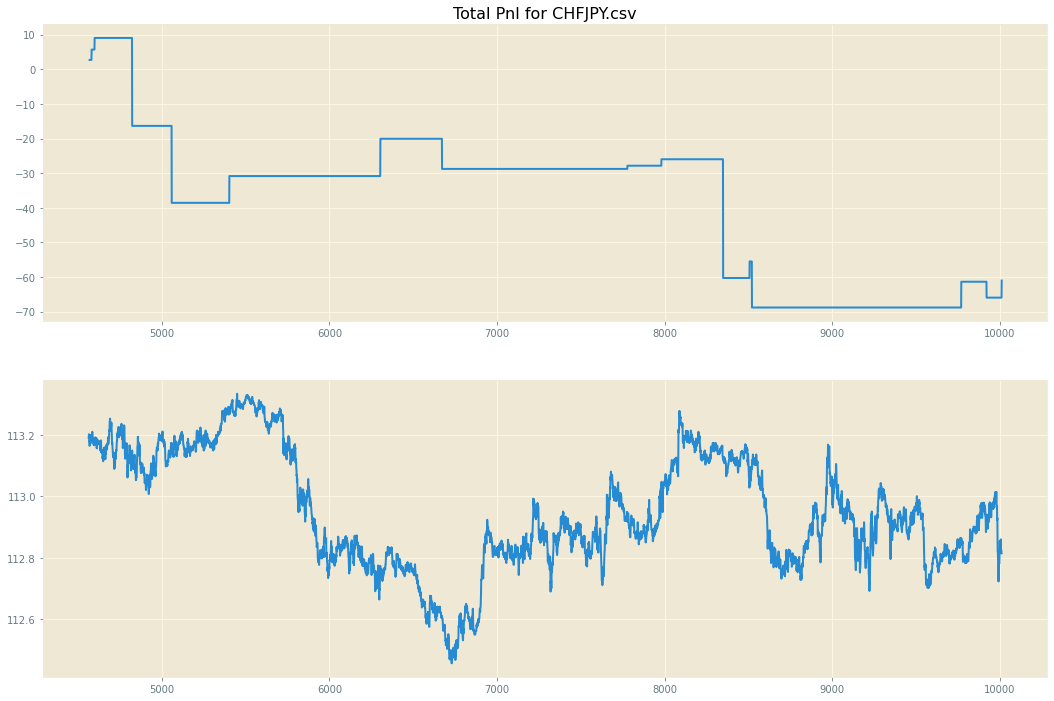

In [8]:
plt.figure(figsize=(18,12))
plt.style.use('Solarize_Light2')
plt.subplot(2,1,1)
plt.plot(stepPnl)
plt.title(f'Total Pnl for {pairName}')
plt.subplot(2,1,2)
plt.plot(range(stepPnl.index[0], inpData.open.iloc[min(copy_df.openIndex):max(copy_df.openIndex)].shape[0] + stepPnl.index[0]), inpData.open.iloc[min(copy_df.openIndex)+stepPnl.index[0]:max(copy_df.openIndex)+stepPnl.index[0]])
plt.show()
plt.show()
